## Import libraries

In [1]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

## Connect DB

In [2]:
database_path = "ezyquant.db"
ez.connect_sqlite(database_path)

## Define universe

In [3]:
start_data = "2008-01-01" # import data
start_date = "2010-01-01" # backtest and report
end_date = _SETDataReaderCached().last_update()

In [4]:
UNIVERSE = ['SET50']
MODEL_NAME = "Change Trend"

In [5]:
ssc = ez.SETSignalCreator(
   start_date=start_data, 
   end_date=end_date, 
   index_list=UNIVERSE,
)

# SET INDEX
sdr = _SETDataReaderCached()
set_index_df = sdr.get_data_index_daily(
                field=fld.D_INDEX_CLOSE,
                index_list=[fld.MARKET_SET],
                start_date=start_data,
                end_date=end_date,
            )

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Import Data

In [6]:
close_df = ssc.get_data(field="close", timeframe='daily')
value_df = ssc.get_data(field="value", timeframe='daily')

sma_10_df = ssc.ta.sma(close_df, 10)
sma_20_df = ssc.ta.sma(close_df, 20)
sma_90_df = ssc.ta.sma(close_df, 90)

pct_90d_df = ssc.ta.roc(close_df, 90)

## Screening Condition

- SMAV(20) < SMAV(90)
- SMAV(10) > SMAV(20)
- %Price Up In 90 days > 10
- Average Trading 20 days > 2e7

Ranking: Top 10 stock with %Price Up In 90 days

In [7]:
# sma cond
sma_10_cond = sma_10_df > sma_20_df
sma_20_cond = sma_20_df < sma_90_df

# pct change 90 days > 10%
pct_90d_cond = pct_90d_df > 10

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

signal_cond = sma_10_cond & sma_20_cond & pct_90d_cond & value_cond


In [8]:
# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)
# replace values that signal == True
pct_90d_df = pd.DataFrame(np.where((signal_df == True)
         , pct_90d_df
         , np.nan
         )
         , columns=signal_df.columns, index=signal_df.index
)

# Top 10 stock that's highest pct change
pos_num = 10
signal_trade = ssc.rank(
    factor_df=pct_90d_df, quantity=pos_num, ascending=False
)  
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(np.where(lookahead_signal == -1
             , -1
             , signal_trade
            )
             , columns=signal_trade.columns, index=signal_trade.index)

## Backtesting

In [9]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0 :
        return c.target_pct_port(1/pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0) # sell
    return 0

# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

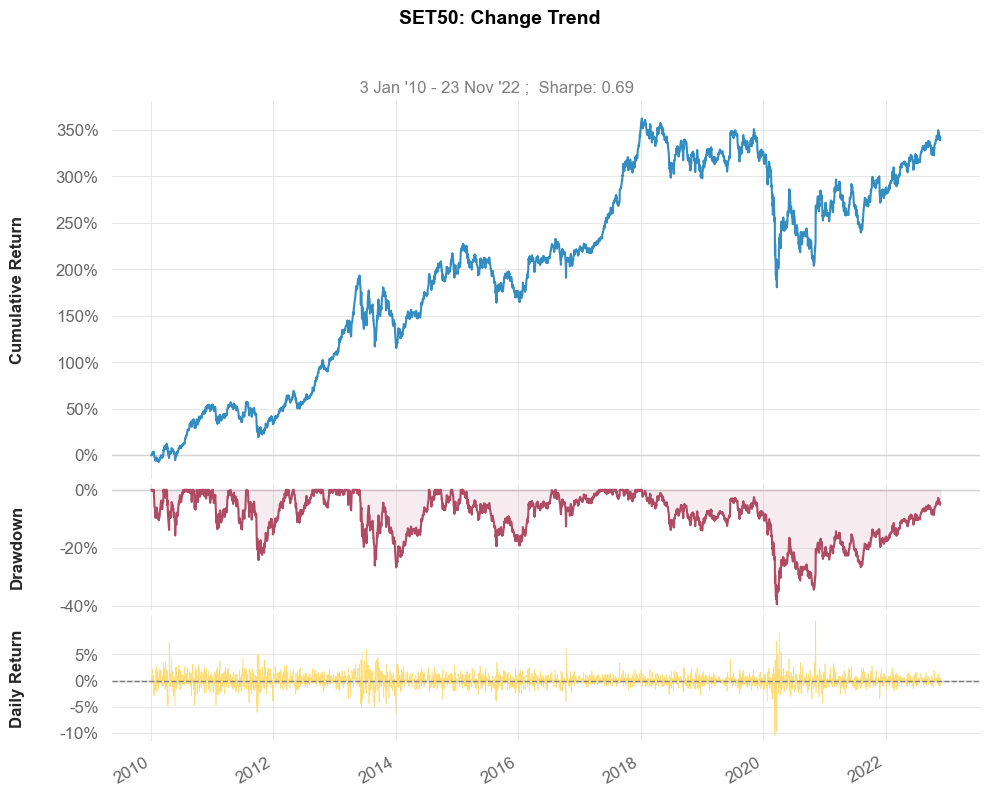

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-04  2010-01-04
End Period                 2022-11-23  2022-11-23
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          340.68%     121.83%
CAGR﹪                     12.19%      6.37%

Sharpe                     0.69        0.47
Prob. Sharpe Ratio         99.26%      95.09%
Smart Sharpe               0.68        0.47
Sortino                    1.0         0.65
Smart Sortino              0.99        0.64
Sortino/√2                 0.71        0.46
Smart Sortino/√2           0.7         0.45
Omega                      1.13        1.13

Max Drawdown               -39.31%     -44.29%
Longest DD Days            1779        1763
Volatility (ann.)          20.08%      16.28%
R^2                        0.75        0.75
Information Ratio          0.04        0.04
Calmar                     0.31      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-09,2020-03-23,2022-11-23,1779,-39.305162,-34.190282
2,2013-05-29,2014-01-03,2014-07-17,414,-26.626864,-25.795455
3,2011-07-26,2011-10-04,2012-03-16,234,-24.153244,-23.297965
4,2015-02-09,2015-08-24,2016-08-08,546,-19.391627,-18.319372
5,2010-04-07,2010-05-25,2010-07-12,96,-15.699240,-14.613844


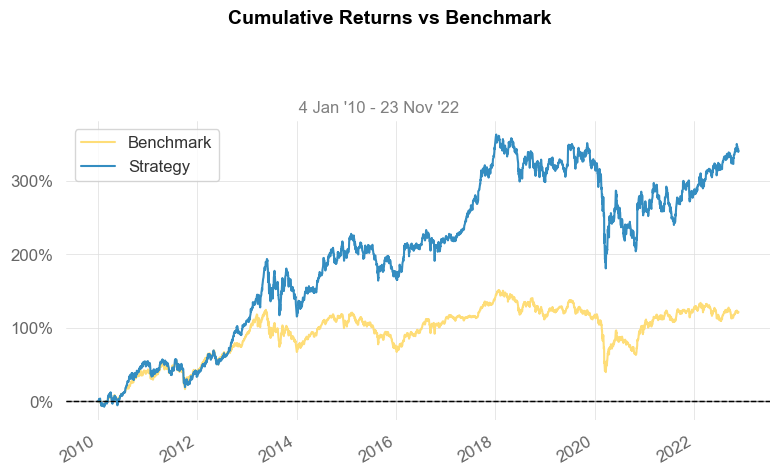

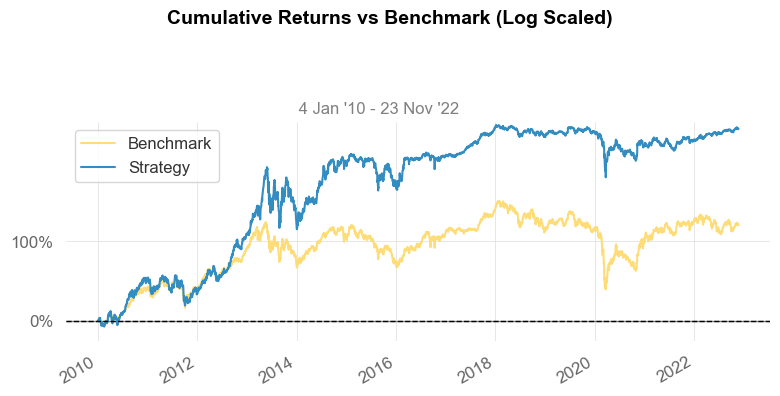

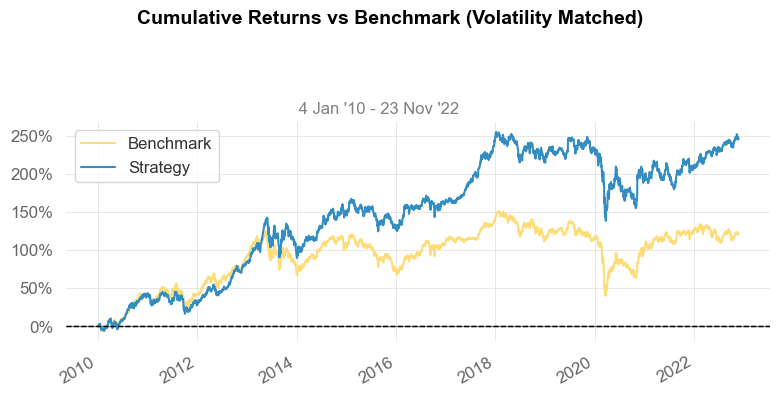

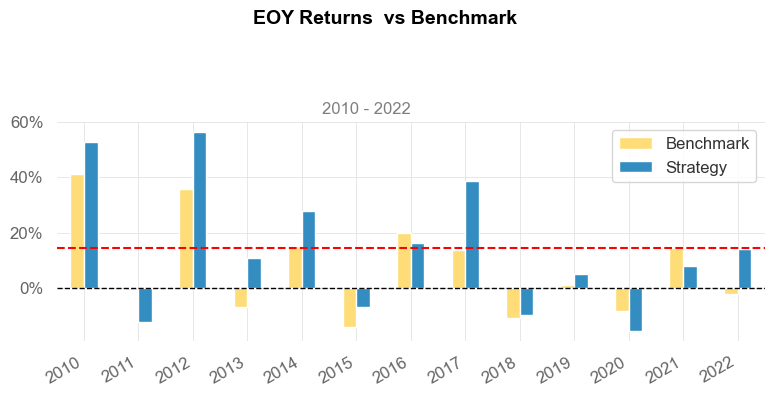

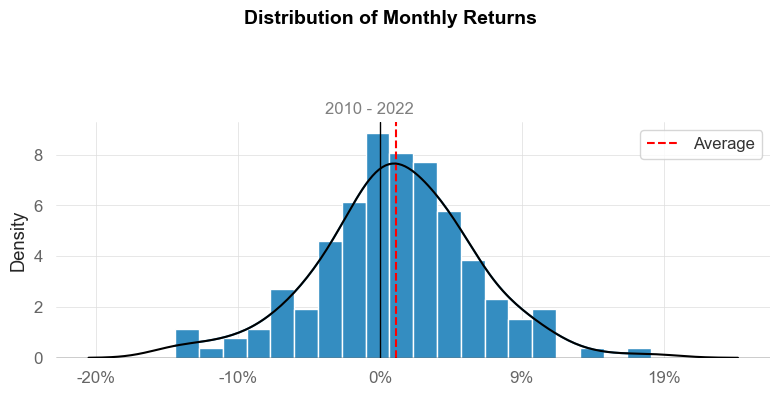

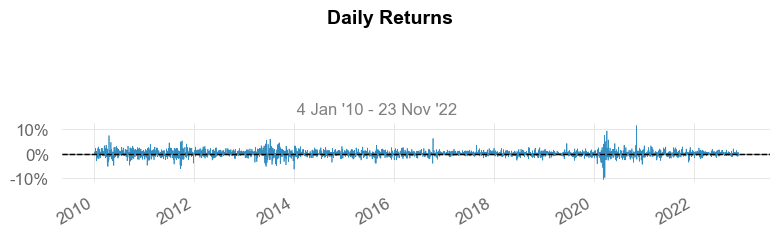

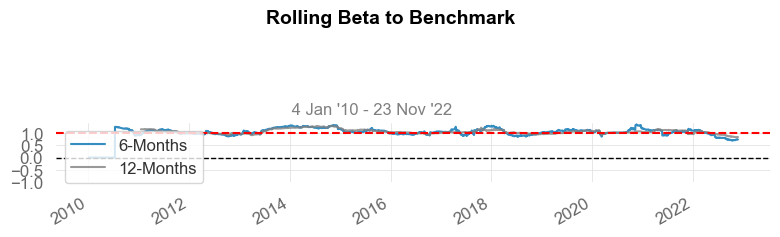

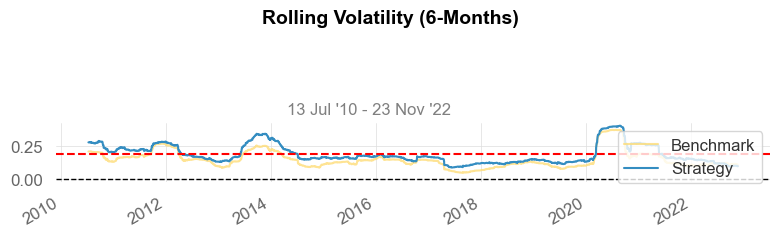

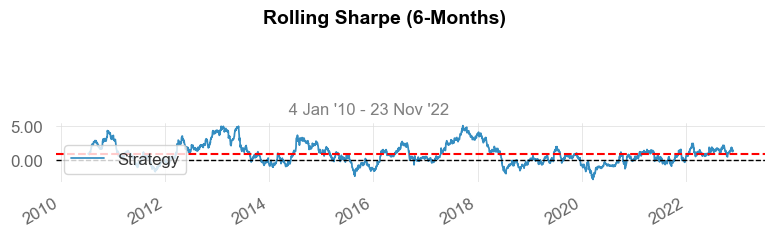

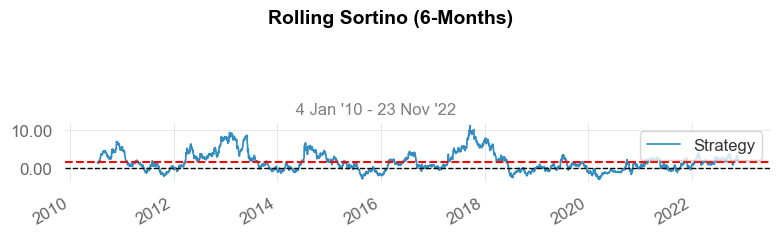

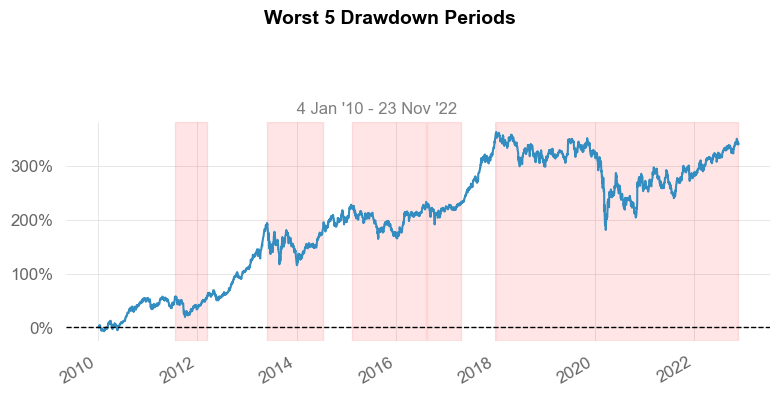

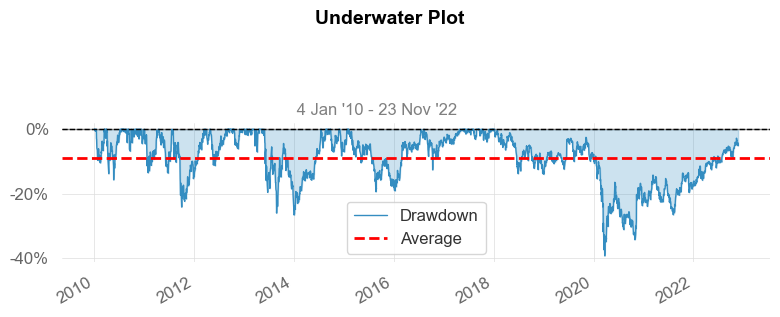

/Users/puwa/opt/anaconda3/envs/finnize/lib/python3.8/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


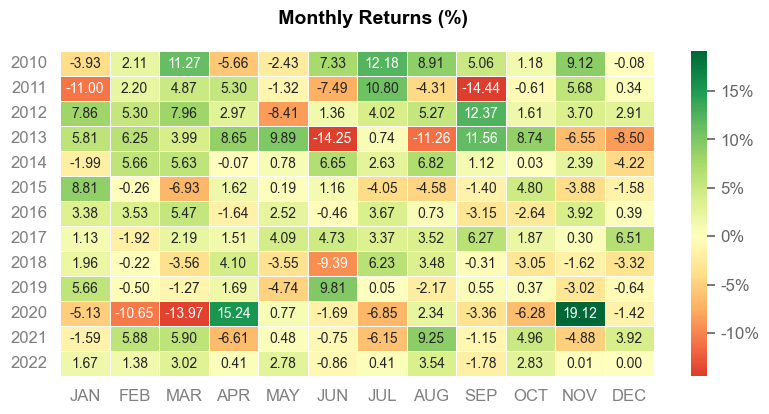

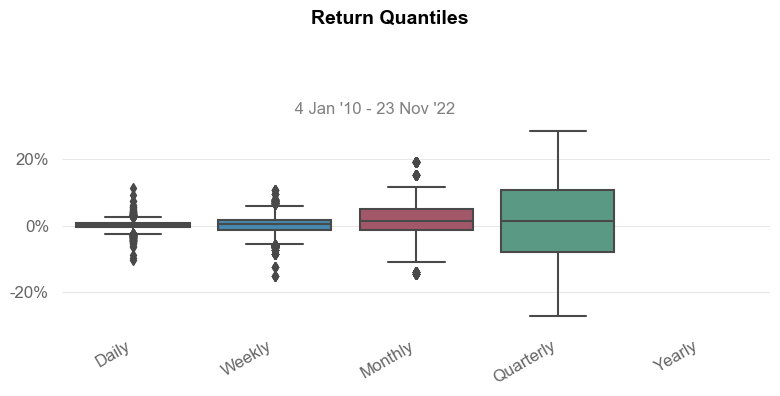

In [14]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(summary_df["port_value_with_dividend"], title=f'{UNIVERSE[0]}: {MODEL_NAME}')
qs.reports.full(summary_df["port_value_with_dividend"], set_index_return["SET"])